/home/timo/projects/vt-ece/ece5984_drl_ai4spp/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


action mask:  tensor([[False, False, False, False, False, False,  True, False,  True, False,
         False, False, False, False, False, False, False,  True, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, 

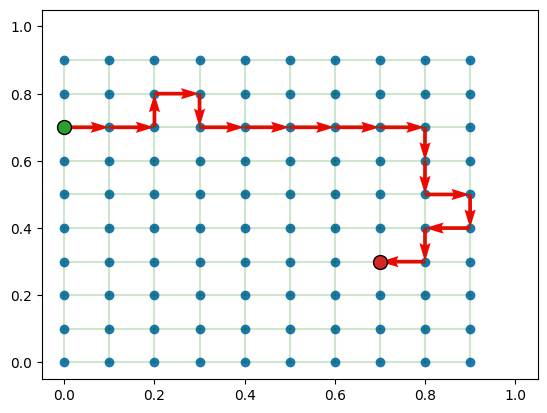

In [2]:
from SPPenv import SPPEnv
from utils import rollout, random_policy

batch_size = 3

env = SPPEnv(num_loc=100)
reward, td, actions = rollout(env, env.reset(batch_size=batch_size), random_policy)
print(reward)
env.render(td, actions)

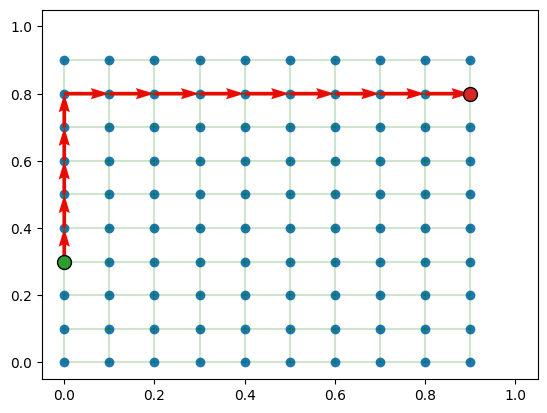

In [3]:
from astar import AStarSearch
from SPPenv import SPPEnv

env = SPPEnv(num_loc=100)
astar = AStarSearch(env)
came_from, _ = astar.search()
astar.render(came_from)

In [4]:
from SPPembeddings import SPPInitEmbedding, SPPContext, StaticEmbedding
from rl4co.models.zoo import AttentionModel, AutoregressivePolicy, POMO, POMOPolicy

env = SPPEnv(num_loc=100)

# policy = AttentionModelPolicy(env.name, 
#                               embedding_dim=128, 
#                               num_encoder_layers=3,
#                               num_heads=8,)

# policy = AutoregressivePolicy(
#     env=env,
#     model=policy,
#     max_steps=100,
#     rollout_fn=rollout,
#     rollout_kwargs={"policy": greedy},
# )

# Instantiate policy with the embeddings we created above
emb_dim = 64
policy = AutoregressivePolicy(env,
                              embedding_dim=emb_dim,
                              init_embedding=SPPInitEmbedding(emb_dim),
                              context_embedding=SPPContext(emb_dim),
                              dynamic_embedding=StaticEmbedding(emb_dim)
)

# model = AttentionModel(env, baseline="rollout",
#                        policy=policy,
#                        train_data_size=100_000,
#                        val_data_size=100_00,
#                        optimizer_kwargs= {"lr": 1e-4},)


policy = POMOPolicy(env,
                        embedding_dim=emb_dim,
                        init_embedding=SPPInitEmbedding(emb_dim),
                        context_embedding=SPPContext(emb_dim),
                        dynamic_embedding=StaticEmbedding(emb_dim))

# policy = POMOPolicy(env,
#                     embedding_dim=emb_dim,
#                     init_embedding=SPPInitEmbedding(emb_dim),
#                     context_embedding=SPPContext(emb_dim),
#                     dynamic_embedding=StaticEmbedding(emb_dim))

model = POMO(env, policy=policy,
                  baseline='shared',
                  batch_size=3,
                  train_data_size=100,
                  val_data_size=10,)

# Model: default is AM with REINFORCE and greedy rollout baseline
# model = AttentionModel(env,
#                        policy=policy,
#                        baseline='rollout',
#                        train_data_size=100_00,
#                        val_data_size=100_0,)

/home/timo/projects/vt-ece/ece5984_drl_ai4spp/.venv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/home/timo/projects/vt-ece/ece5984_drl_ai4spp/.venv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


Problem 1 | Cost: 1000.000
Problem 2 | Cost: 1000.000
Problem 3 | Cost: 1000.000


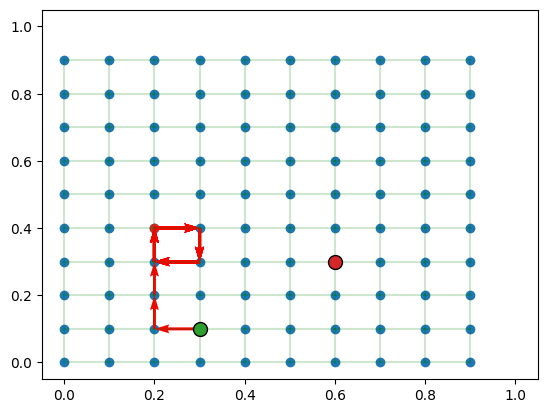

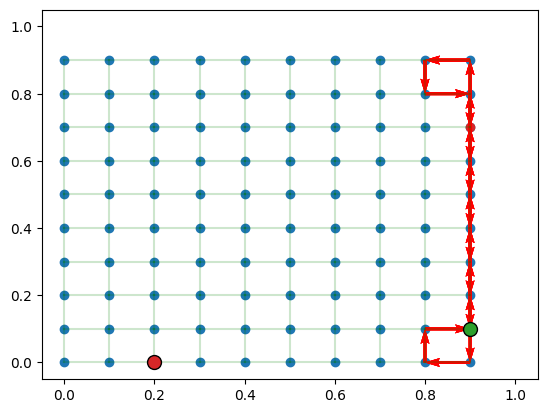

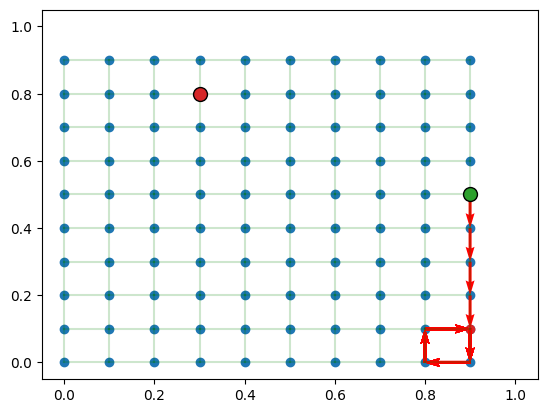

In [5]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)
model = model.to(device)
out = model(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_untrained = out["actions"].cpu().detach()
rewards_untrained = out["reward"].cpu().detach()

for i in range(3):
    print(f"Problem {i+1} | Cost: {-rewards_untrained[i]:.3f}")
    env.render(td_init[i], actions_untrained[i])

In [6]:
from rl4co.utils.trainer import RL4COTrainer

trainer = RL4COTrainer(
    max_epochs=3,
    accelerator="gpu",
    devices=1,
    logger=None
)

trainer.fit(model)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/timo/projects/vt-ece/ece5984_drl_ai4spp/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                 | Params
--------------------------------------------------
0 | env      | SPPEnv               | 0     
1 | policy   | AutoregressivePolicy | 278 K 
2 | baseline | WarmupBaseline       | 278 K 
--------------------------------------------------
556 K     Trainable

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/timo/projects/vt-ece/ece5984_drl_ai4spp/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


/home/timo/projects/vt-ece/ece5984_drl_ai4spp/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/home/timo/projects/vt-ece/ece5984_drl_ai4spp/.venv/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 2: 100%|██████████| 20/20 [00:03<00:00,  5.13it/s, v_num=205, train/reward=-8.56, train/loss=-58.5, val/reward=-6.70]  

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 20/20 [00:04<00:00,  4.76it/s, v_num=205, train/reward=-8.56, train/loss=-58.5, val/reward=-6.70]


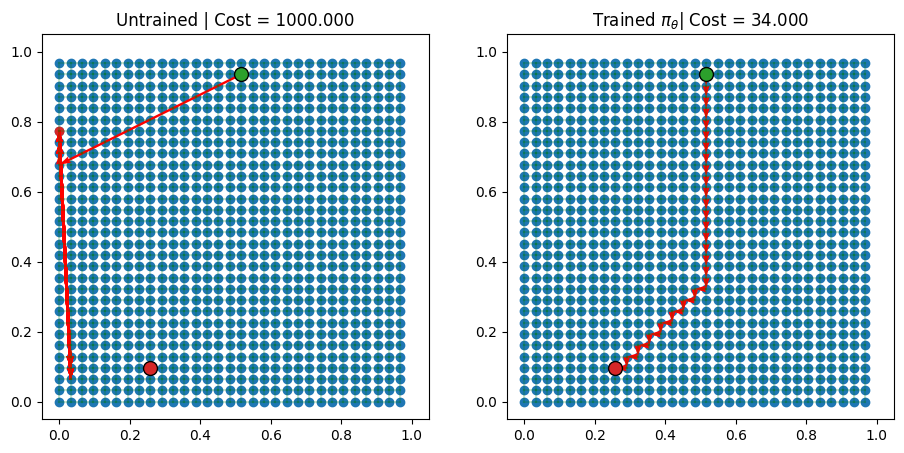

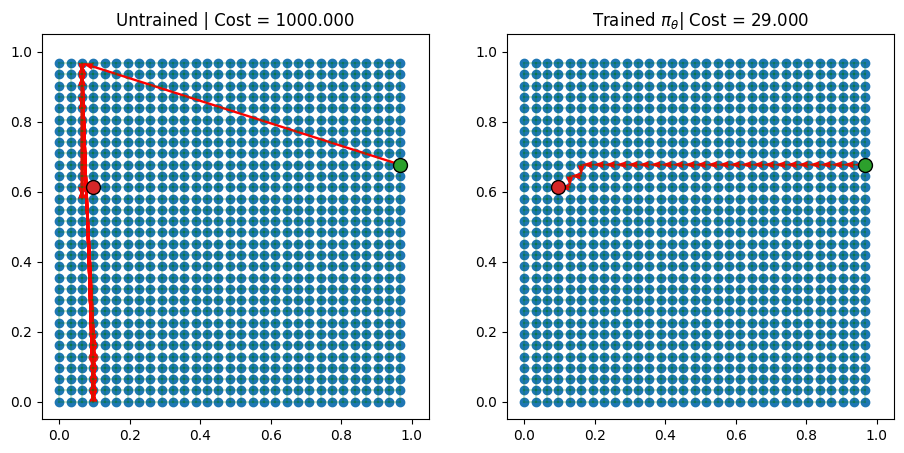

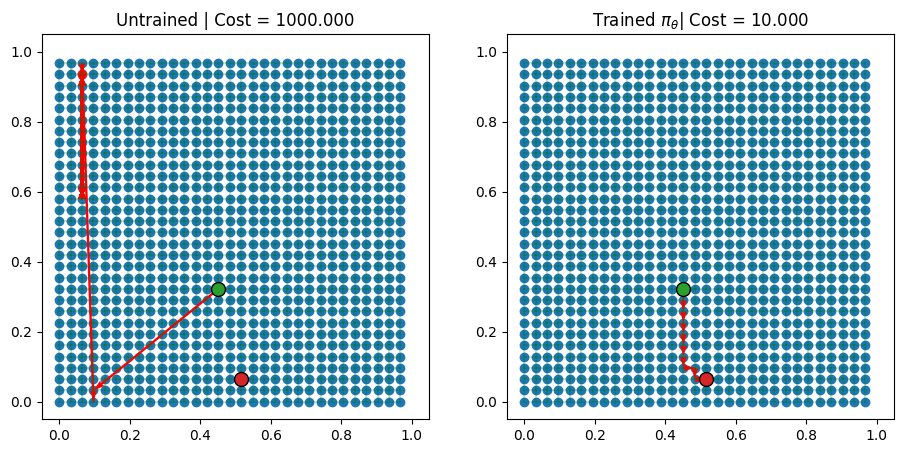

In [10]:
infer_env = SPPEnv(num_loc=1000)
td_init = infer_env.reset(batch_size=[3]).to(device)

model = model.to(device)
out = model(td_init.clone(),env=infer_env, phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,2, figsize=(11,5))
    env.render(td, actions_untrained[i], ax=axs[0])

    infer_env.render(td, actions_trained[i], ax=axs[1])
    axs[0].set_title(f"Untrained | Cost = {-rewards_untrained[i].item():.3f}")
    axs[1].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")